In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers datasets sentencepiece evaluate sacrebleu

In [ ]:
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import Trainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq

from tqdm import tqdm
import evaluate
bleu = evaluate.load("sacrebleu")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Medium/Translation finetune/Yor-Eng.csv")
df = df[["eng", "yor"]]  # Keep only the relevant columns
dataset = Dataset.from_pandas(df)
dataset = dataset.train_test_split(test_size=0.1)

In [ ]:
model_checkpoint = "castorini/afriteva_base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
prefix = "translate English to Yoruba: "

def preprocess_function(example):
    input_text = prefix + example["eng"]
    target_text = example["yor"]

    model_inputs = tokenizer(input_text, max_length=128, truncation=True)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(target_text, max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_dataset = dataset.map(preprocess_function)

Map:   0%|          | 0/1155 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/129 [00:00<?, ? examples/s]

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./afriteva-en-yor",
    learning_rate=2e-4,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=5,
    predict_with_generate=True,
    logging_dir='./logs',
    logging_steps=10,
)

In [ ]:
def compute_metrics(eval_preds):
    predictions, labels = eval_preds

    # Remove ignored index (like -100) in the labels used for loss calculation
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_labels = [[label] for label in decoded_labels]  # BLEU expects list of lists

    result = bleu.compute(predictions=decoded_preds, references=decoded_labels)
    return {"bleu": result["bleu"]}


In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

<ipython-input-13-b0f526adf1a0>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: floraoladipupo (floraoladipupo-federal-university-of-technology-akure) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
10,4.878200
20,3.329800
30,2.796900
40,1.899000
50,1.743800
60,1.783000
70,1.615400
80,1.556300
90,1.638000
100,1.398300


TrainOutput(global_step=1445, training_loss=0.8974020467909974, metrics={'train_runtime': 351.9386, 'train_samples_per_second': 16.409, 'train_steps_per_second': 4.106, 'total_flos': 236082983454720.0, 'train_loss': 0.8974020467909974, 'epoch': 5.0})

In [ ]:
# Create lists for predictions and references
predictions = []
references = []

device = model.device
# Loop through your test dataset
for example in tqdm(tokenized_dataset["test"]):
    # Prepare input
    input_text = "translate English to Yoruba: " + example["eng"]
    inputs = tokenizer(input_text, return_tensors="pt", padding=True, truncation=True).to(device)

    # Generate prediction
    output_ids = model.generate(**inputs, max_new_tokens=50)
    pred = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Append
    predictions.append(pred)
    references.append([example["yor"]])  # BLEU expects list of refs per pred

100%|██████████| 129/129 [01:07<00:00,  1.91it/s]


In [ ]:
results = bleu.compute(predictions=predictions, references=references)
print(f"BLEU Score: {results['score']:.2f}")

BLEU Score: 8.95


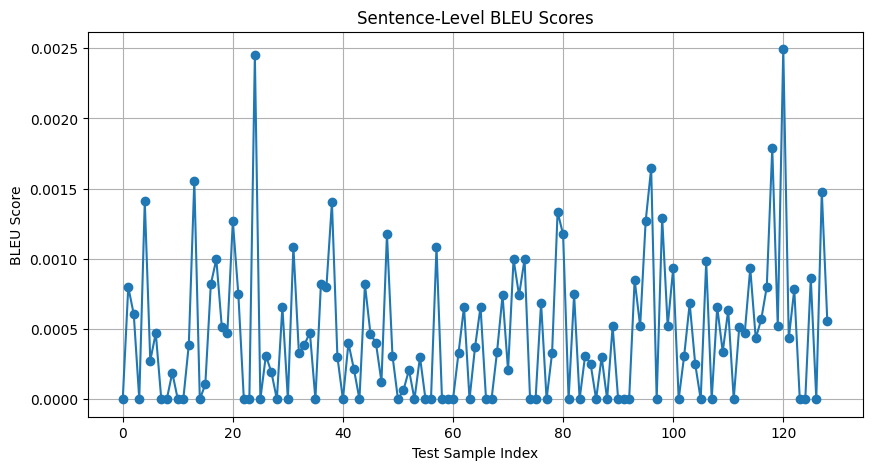

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

smoothie = SmoothingFunction().method4

sentence_bleus = []

for ref, pred in zip(references, predictions):
    score = sentence_bleu(ref, pred.split(), smoothing_function=smoothie)
    sentence_bleus.append(score)
plt.figure(figsize=(10, 5))
plt.plot(sentence_bleus, marker='o')
plt.title("Sentence-Level BLEU Scores")
plt.xlabel("Test Sample Index")
plt.ylabel("BLEU Score")
plt.grid(True)
plt.show()

In [ ]:
model.save_pretrained("/content/drive/MyDrive/Medium/model/afriteva-en-yor-model")
tokenizer.save_pretrained("/content/drive/MyDrive/Medium/model/afriteva-en-yor-model")

('/content/drive/MyDrive/Medium/model/afriteva-en-yor-model/tokenizer_config.json',
 '/content/drive/MyDrive/Medium/model/afriteva-en-yor-model/special_tokens_map.json',
 '/content/drive/MyDrive/Medium/model/afriteva-en-yor-model/tokenizer.json')

In [ ]:
# from huggingface_hub import login
# login()

In [ ]:
# model.push_to_hub("coderGit/afriteva-en-yor")
# tokenizer.push_to_hub("coderGit/afriteva-en-yor")

**Running Inference**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_path = "/content/drive/MyDrive/Medium/model/afriteva-en-yor-model"  # or the path where you saved

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

In [ ]:
def translate(sentence):
    input_text = "translate English to Yoruba: " + sentence
    inputs = tokenizer(input_text, return_tensors="pt", padding=True)
    output = model.generate(**inputs, max_new_tokens=50)
    return tokenizer.decode(output[0], skip_special_tokens=True)

print(translate("Create a pre-historical view of the market roadside"))

ṣe afihan awọn iwoye inu ile ti o nfihan didan pẹlu iwọoorun


In [ ]:
# model = AutoModelForSeq2SeqLM.from_pretrained("coderGit/afriteva-en-yor")
# tokenizer = AutoTokenizer.from_pretrained("coderGit/afriteva-en-yor")